# Table of content # 


1. [ PCA Description ](#desc)

2. [ The Math behind PCA ](#math)

3. [ PCA from scratch ](#code)
    1. [ Import Library ](#import)    
    2. [ Class PCA ](#class)
    3. [ Work with Iris data ](#dataset)

<a name="desc"></a>
## PCA Description

PCA is one of many dimension reduction methods (dim-redction). The idea is simple: find a set of `k` orthogonal vector (`k`<`d`) that approximate the `d` original vector (`d` features). In other word, PCA cut off some redundant feature that has less important. But what important means? The final goal is to keep the interesting, systematic variations between data points. It leads to 2 equivalent soluiton: 
* First answer is that we are looking for some features that strongly differ across data points, thus, PCA looks for features that captures as much variation across data points as possible.

* The second answer is that we are looking for the features that would allow us to "reconstruct" the original features. Imagine that we come up with a feature that has no relation to the original ones; If we were to use this new feature, there is no way we can relate this to the original ones. So PCA looks for features that minimizes the reconstruction error.

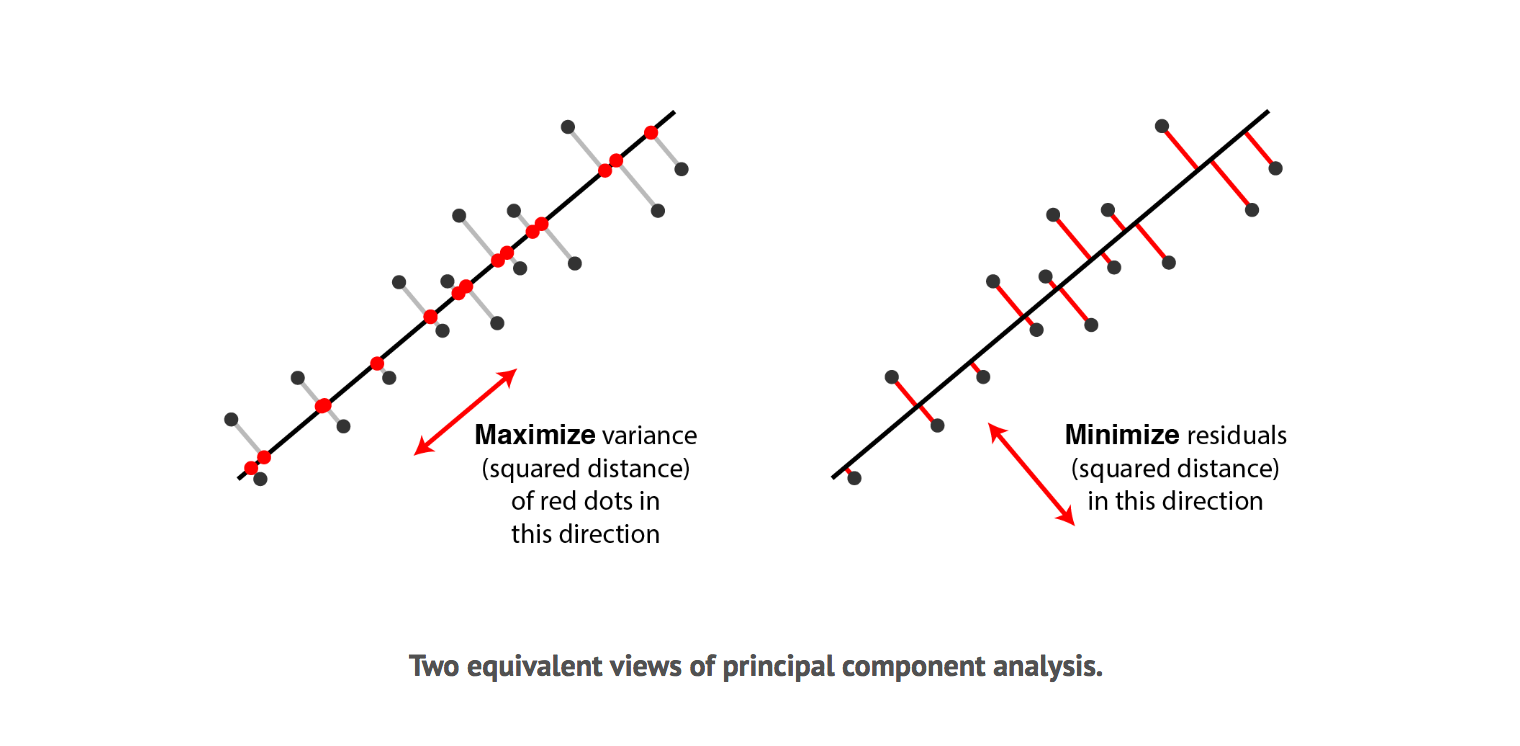

The 2 solution is equivalent that basically infered by Pythagorean theorem.


**Application: Face-matching**

*"Each point $x(i) \in R^{100 \times 100}$ was a 10000 dimensional vector, with each coordinate corresponding to a pixel intensity value in a 100x100 image of a face. Using PCA, we represent each image $x(i)$ with a much lower-dimensional $y(i)$. In doing so, we hope that the principal components we found retain the interesting, systematic variations between faces that capture what a person really looks like, but not the “noise” in the images introduced by minor lighting variations, slightly different imaging conditions, and so on. We then measure distances between faces i and j by working in the reduced dimension, and computing $||y(i) −y
(j)||_2$. This resulted in a surprisingly good face-matching and retrieval algorithm "*

<a name="math"></a>
## The Math behind PCA


To begin with, there are some annotations in PCA:
* x(i) : data point $i^{th}$ in high-dim, standardized to zero mean and variance 1 ($x \leftarrow \frac{x - \mu }{\sigma}$)
* y(i) : data point $i^{th}$ in low-dim, ($y(i) = u^\top x(i) $)
* u: project vector, this is `trainable` parameter
* $\Sigma$: Covariance of data points

Let consider PCA's objective function: maximize variance of projected data points y(i)

\begin{align}
\Sigma =\frac{1}{n}(\mathbf{Y})^\top \mathbf{Y} = \frac{1}{n}(\mathbf{Xu})^\top \mathbf{Xu} = \mathbf u^\top (\frac{1}{n}\mathbf X^\top\mathbf X) \mathbf u = \mathbf u^\top \mathbf{Cu}
\end{align}
(I used 1/n instead of 1/(n-1) due to the assumption  $d << n$)

$C =\frac{1}{n}\mathbf (X-\mu_X) ^\top\mathbf (X-\mu_X) = \frac{1}{n}\mathbf (X) ^\top\mathbf (X)  $ which is just the empirical covariance matrix of the data (assuming it has zero mean, if not, we standardize X). 

So far so good, we did transform the covariance of projected points into simple form. However, it is still impossible to find the optimum value because the formula are unchanged whenever we scale `u` by arbitrary number, thus we should constraints `u` into  a unit vector: $u^\top u= 1$

Apply Lagrange multiplier, we try to minimize the loss function:
\begin{align}
L &= \mathbf u^\top \mathbf{Cu}-\lambda(\mathbf u^\top \mathbf u-1)
\end{align}

\begin{align}
\frac{\partial L}{\partial \mathbf w} 
& = \mathbf{Cw} - \lambda \mathbf w = 0 \\
& => \mathbf{Cw} = \lambda \mathbf w
\end{align}

This lead to a familiar equation of finding eigenvalues and eigenvectors of C.

<a name="code"></a>
## PCA from scratch


<a name="import"></a>
### Import library

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
# %load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

<a name="class"></a>
### class PCA

In [23]:
def standardize(X): # X: (nxd), standardize along all examples of each feature (axis = 0)
    return (X-np.mean(X, axis = 0))/np.std(X, axis = 0) 

def covariance(X_std): # this may be different to np.cov because n is not large enough
    n = len(X)
    return 1/n*(X_std.T @ X_std)

class PCA:
    """
    Principal component analysis (PCA)
    
    Parameters
    ----------
    n_components : int
        top number of principal components to keep
    """
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, X):
        # standardization
        X_std = standardize(X)
        
        # empircal covariance C
        C = covariance(X_std)
    
        # eigendecomposition
        eig_vals, eig_vecs = np.linalg.eig(C) # this function is sorted by descending order.
        var_exp = eig_vals / np.sum(eig_vals)
        self.explained_variance_ratio = var_exp[:self.n_components]
        
        # k principle components
        self.k_eig_vecs = eig_vecs[:, :self.n_components]
        
        return self

<a name="dataset"></a>
### Work with Iris dataset

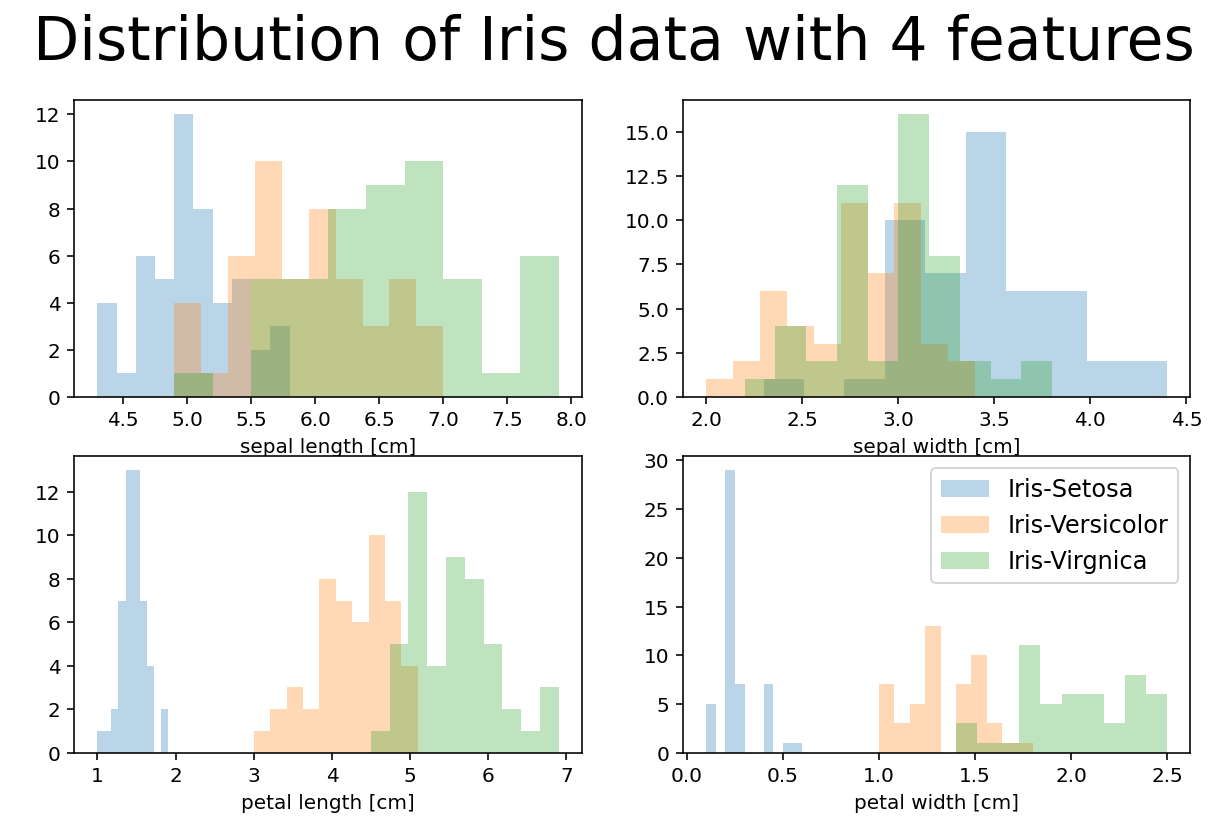

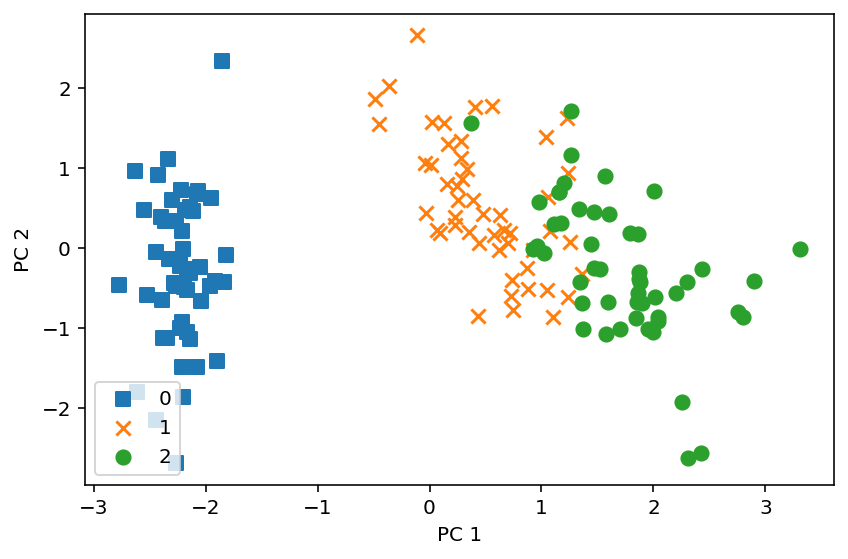

PCA Explained variance ratio:  [0.72962445 0.22850762]


In [21]:
iris = load_iris()
X = iris['data']
y = iris['target']

label_dict = {
    0: 'Iris-Setosa',
    1: 'Iris-Versicolor',
    2: 'Iris-Virgnica'}

feature_dict = {
    0: 'sepal length [cm]',
    1: 'sepal width [cm]',
    2: 'petal length [cm]',
    3: 'petal width [cm]'}

fig = plt.figure(figsize = (10, 6))
for feature in range(len(feature_dict)):
    plt.subplot(2, 2, feature + 1)
    for index, label in label_dict.items():
        plt.hist(X[y == index, feature], label = label,
                 bins = 10, alpha = 0.3)
        plt.xlabel(feature_dict[feature])
        
plt.legend(loc = 'upper right', fancybox = True, fontsize = 12)
# plt.tight_layout()
fig.suptitle(' Distribution of Iris data with 4 features ', fontsize=30)

plt.show()

def plot_iris_pca(X_pca, y):
    """a scatter plot of the 2-dimensional iris data"""
    markers = 's', 'x', 'o'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.show()

pca = PCA(n_components= 2)
X_std = standardize(X)
model = pca.fit(X)

z = X_std @ model.k_eig_vecs
plot_iris_pca(z, y)
print("PCA Explained variance ratio: ", model.explained_variance_ratio)

## Refs


http://cs229.stanford.edu/syllabus-summer2019.html
https://github.com/ethen8181/machine-learning/blob/master/dim_reduct/PCA.ipynb